## Wild test of the CNN model

This is the assessment of how well the model generalizes on real-life images. The logic behind: raw predictions → confidence → metrics → interpretation

In [1]:
import os
import numpy as np
import tensorflow as tf

from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# 1) Paths
MODEL_PATH = Path("../models/image_classification_model.keras")
WILD_DIR   = Path("../data/wild_test")  # change if you store it elsewhere

In [3]:
# 2) Class mapping (must match training order)
class_names = [
    "Bacterial_spot",
    "Early_blight",
    "Late_blight",
    "Leaf_Mold",
    "Septoria_leaf_spot",
    "Spider_mites_Two_spotted_spider_mite",
    "Target_Spot",
    "YellowLeaf__Curl_Virus",
    "healthy",
    "mosaic_virus",
]
class_to_idx = {c: i for i, c in enumerate(class_names)}

In [4]:
# 3) Load model
model = tf.keras.models.load_model(MODEL_PATH)
print("Loaded model:", MODEL_PATH)




Loaded model: ..\models\image_classification_model.keras


In [5]:
# 4) Collect image files + labels from folder structure
img_paths = []
y_true = []

valid_ext = {".jpg", ".jpeg", ".png", ".webp"}

for cls in class_names:
    cls_dir = WILD_DIR / cls
    if not cls_dir.exists():
        print(f"WARNING: Missing folder: {cls_dir}")
        continue

    for p in cls_dir.rglob("*"):
        if p.suffix.lower() in valid_ext:
            img_paths.append(p)
            y_true.append(class_to_idx[cls])

img_paths = np.array(img_paths, dtype=object)
y_true = np.array(y_true, dtype=int)

print("Wild images found:", len(img_paths))
if len(img_paths) == 0:
    raise ValueError("No images found. Check WILD_DIR and folder names.")

Wild images found: 50


In [6]:
# 5) Image loader (RGB + resize)
IMG_SIZE = (256, 256)

def load_one_image(path: Path) -> tf.Tensor:
    raw = tf.io.read_file(str(path))
    img = tf.image.decode_image(raw, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)  # keep as float; model has Rescaling inside
    return img

In [7]:
# 6) Predict in batches (store probs too)
BATCH = 16
probs_all = []

for i in range(0, len(img_paths), BATCH):
    batch_paths = img_paths[i:i+BATCH]
    batch_imgs = tf.stack([load_one_image(p) for p in batch_paths], axis=0)
    probs = model.predict(batch_imgs, verbose=0)
    probs_all.append(probs)

probs_all = np.vstack(probs_all)               # shape: (N, num_classes)
y_pred = np.argmax(probs_all, axis=1)          # predicted class index
y_pred_conf = np.max(probs_all, axis=1)        # confidence of predicted class

print("\nConfidence statistics:")
print(f"  Mean confidence:   {y_pred_conf.mean():.3f}")
print(f"  Median confidence: {np.median(y_pred_conf):.3f}")
print(f"  Min confidence:    {y_pred_conf.min():.3f}")
print(f"  Max confidence:    {y_pred_conf.max():.3f}")


Confidence statistics:
  Mean confidence:   0.704
  Median confidence: 0.680
  Min confidence:    0.346
  Max confidence:    1.000


In [8]:

# ---- Accuracy by confidence bucket ----
import pandas as pd

df_conf = pd.DataFrame({
    "correct": (y_true == y_pred),
    "conf": y_pred_conf
})

bins = [0.0, 0.5, 0.7, 0.85, 1.0]
df_conf["conf_bin"] = pd.cut(df_conf["conf"], bins=bins)

acc_by_bin = df_conf.groupby("conf_bin")["correct"].mean()

print("\nAccuracy by confidence bin:")
print(acc_by_bin)



Accuracy by confidence bin:
conf_bin
(0.0, 0.5]     0.181818
(0.5, 0.7]     0.071429
(0.7, 0.85]    0.333333
(0.85, 1.0]    0.526316
Name: correct, dtype: float64


C:\Users\ogina\AppData\Local\Temp\ipykernel_23060\987749688.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_bin = df_conf.groupby("conf_bin")["correct"].mean()


In [9]:
# 7) Metrics
acc = accuracy_score(y_true, y_pred)
print("Wild accuracy:", acc)

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix (rows=true, cols=pred):")
print(cm)

Wild accuracy: 0.3

Classification report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.00      0.00      0.00         5
                        Early_blight       0.43      0.60      0.50         5
                         Late_blight       0.00      0.00      0.00         5
                           Leaf_Mold       0.50      0.80      0.62         5
                  Septoria_leaf_spot       0.27      0.80      0.40         5
Spider_mites_Two_spotted_spider_mite       0.00      0.00      0.00         5
                         Target_Spot       0.00      0.00      0.00         5
              YellowLeaf__Curl_Virus       0.00      0.00      0.00         5
                             healthy       0.43      0.60      0.50         5
                        mosaic_virus       0.17      0.20      0.18         5

                            accuracy                           0.30        50
                   

c:\Users\ogina\Desktop\DS_Bootcamp\Capstone_Project\image_clasification_model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ogina\Desktop\DS_Bootcamp\Capstone_Project\image_clasification_model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ogina\Desktop\DS_Bootcamp\Capstone_Project\image_clasification_model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

Finding the worst mistakes (model certain but wrong) and the most uncertain cases (ambiguous).

Total wild images: 50
Correct: 15 | Wrong: 35

=== Confident but wrong (top 12) ===


,file,true,pred,conf,top3,path
2,bacterialspotontomatoXant.png,Bacterial_spot,Septoria_leaf_spot,0.999933,"[(Septoria_leaf_spot, 0.9999334812164307), (Ba...",..\data\wild_test\Bacterial_spot\bacterialspot...
43,tomato.jpg,healthy,Late_blight,0.999899,"[(Late_blight, 0.9998992681503296), (Leaf_Mold...",..\data\wild_test\healthy\tomato.jpg
26,spider-mite-damage.jpg,Spider_mites_Two_spotted_spider_mite,Late_blight,0.999746,"[(Late_blight, 0.9997455477714539), (Leaf_Mold...",..\data\wild_test\Spider_mites_Two_spotted_spi...
11,late-blight-potato.jpg,Late_blight,Septoria_leaf_spot,0.955488,"[(Septoria_leaf_spot, 0.9554882645606995), (Ea...",..\data\wild_test\Late_blight\late-blight-pota...
28,two-spotted-spider-mite-tomato.jpg,Spider_mites_Two_spotted_spider_mite,healthy,0.932507,"[(healthy, 0.9325068593025208), (Late_blight, ...",..\data\wild_test\Spider_mites_Two_spotted_spi...
48,mosaic-virus.png,mosaic_virus,healthy,0.929475,"[(healthy, 0.9294754266738892), (Leaf_Mold, 0....",..\data\wild_test\mosaic_virus\mosaic-virus.png
13,potato_late-blight.jpeg,Late_blight,Leaf_Mold,0.924163,"[(Leaf_Mold, 0.9241634011268616), (YellowLeaf_...",..\data\wild_test\Late_blight\potato_late-blig...
47,mosaic-virus-apple.jpg,mosaic_virus,YellowLeaf__Curl_Virus,0.919632,"[(YellowLeaf__Curl_Virus, 0.9196318984031677),...",..\data\wild_test\mosaic_virus\mosaic-virus-ap...
31,soybeans_Target_spot_shothole.jpeg,Target_Spot,Early_blight,0.912677,"[(Early_blight, 0.9126772284507751), (Septoria...",..\data\wild_test\Target_Spot\soybeans_Target_...
29,two-spotted-spider-mite.png,Spider_mites_Two_spotted_spider_mite,Late_blight,0.839995,"[(Late_blight, 0.8399950265884399), (Leaf_Mold...",..\data\wild_test\Spider_mites_Two_spotted_spi...



=== Most uncertain (lowest confidence, top 12) ===


,file,true,pred,conf,top3,path
8,early_blight_leafcux1200.jpg,Early_blight,Septoria_leaf_spot,0.345618,"[(Septoria_leaf_spot, 0.34561848640441895), (E...",..\data\wild_test\Early_blight\early_blight_le...
16,leaf-mold-tomato-1.jpg,Leaf_Mold,Leaf_Mold,0.356542,"[(Leaf_Mold, 0.3565424382686615), (Early_bligh...",..\data\wild_test\Leaf_Mold\leaf-mold-tomato-1...
38,yellow-leaf-curl-tomato.jpg,YellowLeaf__Curl_Virus,mosaic_virus,0.364483,"[(mosaic_virus, 0.3644832670688629), (healthy,...",..\data\wild_test\YellowLeaf__Curl_Virus\yello...
42,SoybeanLeaves_0.jpg,healthy,healthy,0.384303,"[(healthy, 0.3843032121658325), (mosaic_virus,...",..\data\wild_test\healthy\SoybeanLeaves_0.jpg
36,Tomato-Leaf-Curl.jpg,YellowLeaf__Curl_Virus,mosaic_virus,0.389505,"[(mosaic_virus, 0.3895047903060913), (Septoria...",..\data\wild_test\YellowLeaf__Curl_Virus\Tomat...
1,bacterial-leaf-spot.jpg,Bacterial_spot,Early_blight,0.391722,"[(Early_blight, 0.39172154664993286), (Septori...",..\data\wild_test\Bacterial_spot\bacterial-lea...
32,target-spot-1.jpg,Target_Spot,Leaf_Mold,0.400274,"[(Leaf_Mold, 0.40027445554733276), (healthy, 0...",..\data\wild_test\Target_Spot\target-spot-1.jpg
44,tomato_1.jpg,healthy,Target_Spot,0.453461,"[(Target_Spot, 0.45346149802207947), (Septoria...",..\data\wild_test\healthy\tomato_1.jpg
19,leaf_mold_tomato1x1200.jpg,Leaf_Mold,Septoria_leaf_spot,0.460181,"[(Septoria_leaf_spot, 0.46018144488334656), (E...",..\data\wild_test\Leaf_Mold\leaf_mold_tomato1x...
25,soybeanresearch-Two-spotted-Spider-Mite-3.jpg,Spider_mites_Two_spotted_spider_mite,Leaf_Mold,0.484982,"[(Leaf_Mold, 0.4849819242954254), (Late_blight...",..\data\wild_test\Spider_mites_Two_spotted_spi...



Confident but wrong (showing 6)


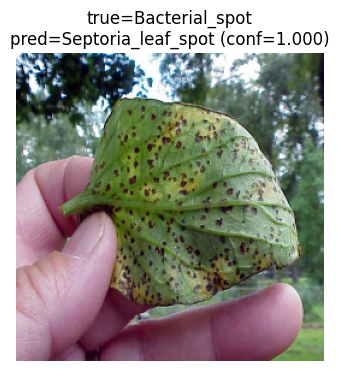

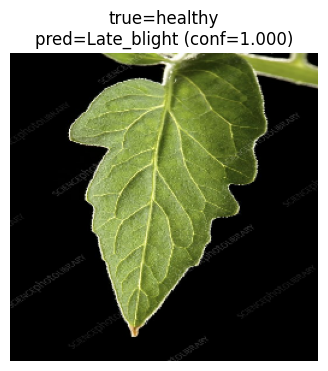

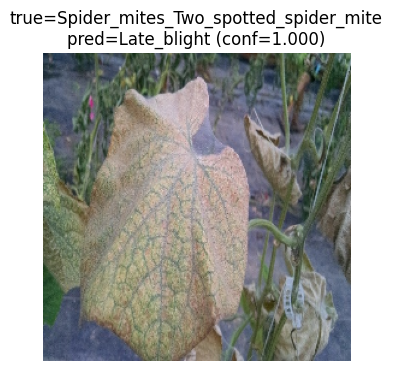

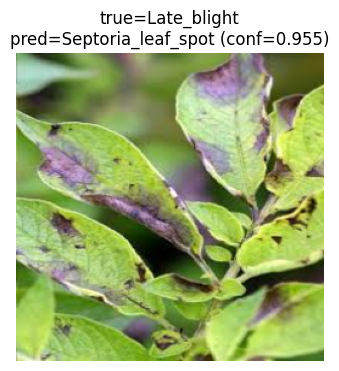

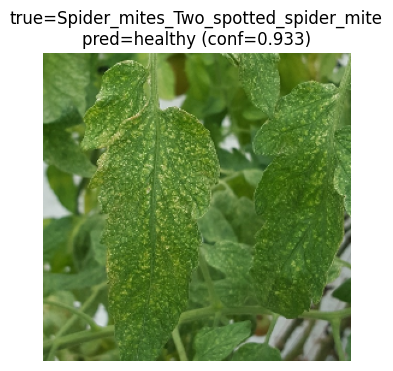

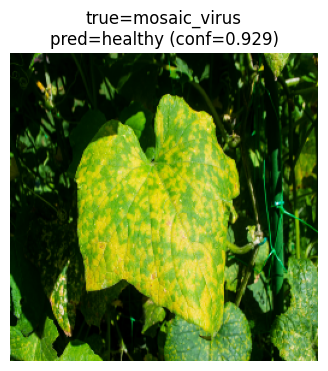


Most uncertain (showing 6)


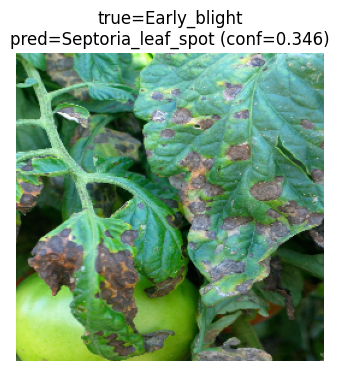

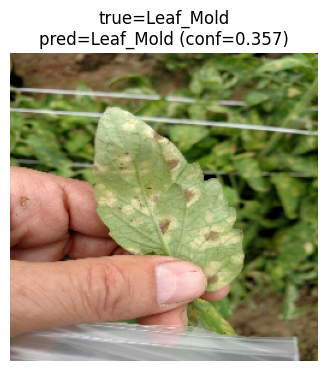

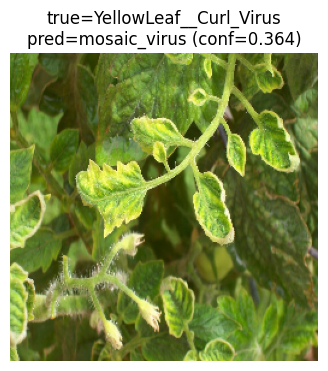

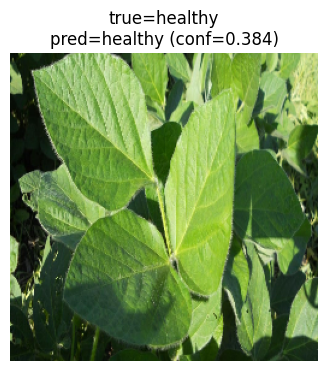

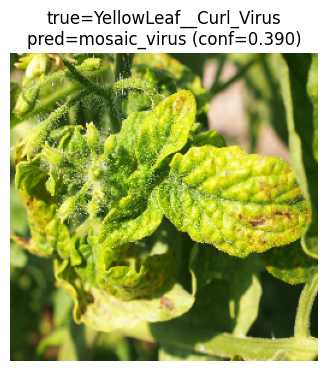

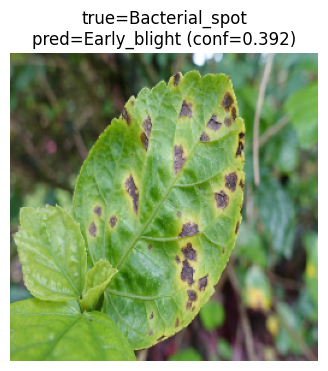

In [10]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

# Build a results table
rows = []
for path, yt, yp, conf, prob_vec in zip(img_paths, y_true, y_pred, y_pred_conf, probs_all):
    top3_idx = prob_vec.argsort()[-3:][::-1]
    top3 = [(class_names[i], float(prob_vec[i])) for i in top3_idx]
    rows.append({
        "path": str(path),
        "file": Path(path).name,
        "true": class_names[int(yt)],
        "pred": class_names[int(yp)],
        "conf": float(conf),
        "top3": top3
    })

df = pd.DataFrame(rows)
df["correct"] = df["true"] == df["pred"]

print("Total wild images:", len(df))
print("Correct:", int(df["correct"].sum()), "| Wrong:", int((~df["correct"]).sum()))

# --- 1) Confident but wrong (most important failures)
confident_wrong = df[~df["correct"]].sort_values("conf", ascending=False).head(12)

print("\n=== Confident but wrong (top 12) ===")
display(confident_wrong[["file", "true", "pred", "conf", "top3", "path"]])

# --- 2) Most uncertain predictions (lowest confidence) - often ambiguous images
most_uncertain = df.sort_values("conf", ascending=True).head(12)

print("\n=== Most uncertain (lowest confidence, top 12) ===")
display(most_uncertain[["file", "true", "pred", "conf", "top3", "path"]])

# --- 3) Optional: show images inline
SHOW_IMAGES = True

def show_examples(subdf, title, n=6):
    if len(subdf) == 0:
        print(f"\n{title}: none")
        return
    n = min(n, len(subdf))
    print(f"\n{title} (showing {n})")
    for _, r in subdf.head(n).iterrows():
        img = load_one_image(Path(r["path"]))  # Tensor (256,256,3), float32
        img = tf.cast(tf.clip_by_value(img / 255.0, 0, 1), tf.float32)  # for display only
        plt.figure(figsize=(4, 4))
        plt.imshow(img.numpy())
        plt.axis("off")
        plt.title(f"true={r['true']}\npred={r['pred']} (conf={r['conf']:.3f})")
        plt.show()

if SHOW_IMAGES:
    show_examples(confident_wrong, "Confident but wrong")
    show_examples(most_uncertain, "Most uncertain")


Saving the results of "confident but wrong".

In [11]:
from pathlib import Path

OUT_DIR = Path("../reports")   # or wherever you like
OUT_DIR.mkdir(parents=True, exist_ok=True)

confident_wrong = df[~df["correct"]].sort_values("conf", ascending=False)

out_path = OUT_DIR / "wild_confident_wrong.csv"
confident_wrong.to_csv(out_path, index=False)

print("Saved:", out_path.resolve())
print("Rows:", len(confident_wrong))


Saved: C:\Users\ogina\Desktop\DS_Bootcamp\Capstone_Project\image_clasification_model\reports\wild_confident_wrong.csv
Rows: 35


In [12]:
(df.sort_values("conf", ascending=False)
   .to_csv(OUT_DIR / "wild_all_predictions.csv", index=False))
